In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pylab
import sys
# making sure the dl4mt module is on the path 
# -- this path depends upon the location where the notebook is running
# here it is assumed to be the day1/ directory
sys.path.append('../..')

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%writefile ../../dl4mt/mlp.py
# Uncomment to save this cell to file in order to import it in later notebooks

# construct an MLP graph using theano, then train and evaluate using static features
import numpy
import theano
import theano.tensor as T

# this is our logistic regression class, created and saved in the LogisticRegression notebook
from dl4mt.logistic_regression import LogisticRegression

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


class MLP(object):
    """Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softmax layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )
        
        # alias to logRegressionLayer.y_pred to provide a consistent interface to our models
        self.y_pred = self.logRegressionLayer.y_pred

        # L1 norm
        self.L1 = (
            abs(self.hiddenLayer.W).sum()
            + abs(self.logRegressionLayer.W).sum()
        )

        # L2 norm
        self.L2_sqr = (
            (self.hiddenLayer.W ** 2).sum()
            + (self.logRegressionLayer.W ** 2).sum()
        )

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params

        # keep track of model input -- this will be useful for creating theano functions
        self.input = input

Overwriting ../../dl4mt/mlp.py


In [8]:
import numpy

import theano
import theano.tensor as T
import timeit

from dl4mt.mlp import MLP


def initialize_mlp(train_dataset, dev_dataset, learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, 
                   batch_size=10, n_hidden=500):
    
    """Intialize the functions and parameters needed to train a multilayer perceptron

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization)

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization)

    :type training_epochs: int
    :param training_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: the path of the MNIST dataset file from
                 http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz


   """

    train_set_x, train_set_y = train_dataset
    valid_set_x, valid_set_y = dev_dataset

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(1234)
    
    # TODO: move these into the parameterization of the training function
    n_in = train_set_x.get_value().shape[1]
    n_out = 12
    
    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=n_in,
        n_hidden=n_hidden,
        n_out=n_out
    )

    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )

    validate_model_func = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameters of the model based on the rules
    # defined in `updates`
    train_model_func = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    return (classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches)

In [9]:
# Challenge: implement multiple hidden layers to make this a true "Multilayer Perceptron", 
# how does the performance of the model change?

In [10]:
# TODO: allow user to load another distributed representation for comparison, such as PCA
import os

from dl4mt.datasets import prep_dataset
from dl4mt.training import train_model

# location of our datasets
DATASET_LOCATION = '../../datasets/'

# the pos dataset consists of windows around words
POS_DATASET_NAME = 'brown_pos_dataset.hdf5'
POS_DATASET_PATH = os.path.join(DATASET_LOCATION, POS_DATASET_NAME)
WORD_BY_WORD_MATRIX = 'brown.word-by-word.normalized.npy'
VECTOR_INDEX_PATH = os.path.join(DATASET_LOCATION, WORD_BY_WORD_MATRIX)

CUTOFF = 50000
  
train_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'], cutoff=CUTOFF)
dev_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['dev'], cutoff=CUTOFF)

# train the MLP
initialization_data = initialize_mlp(train_dataset, dev_dataset, learning_rate=0.01, batch_size=50)

classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches = initialization_data


# load the training function and train the LR model 
# TODO: -- train_model should return the validation error as a list, then we can plot it
# in general, train_model should return any useful information about the training process
train_model(train_model_func, n_train_batches, validate_model=validate_model_func,
            n_valid_batches=n_valid_batches, training_epochs=10)

epoch 1, minibatch 1000/1000, validation error 25.802048 %
epoch 1, average training cost 1.08
epoch 2, minibatch 1000/1000, validation error 20.229807 %
epoch 2, average training cost 0.63
epoch 3, minibatch 1000/1000, validation error 17.497156 %
epoch 3, average training cost 0.53
epoch 4, minibatch 1000/1000, validation error 16.045506 %
epoch 4, average training cost 0.48
epoch 5, minibatch 1000/1000, validation error 15.230944 %
epoch 5, average training cost 0.44
epoch 6, minibatch 1000/1000, validation error 14.732651 %
epoch 6, average training cost 0.42
epoch 7, minibatch 1000/1000, validation error 14.473265 %
epoch 7, average training cost 0.40
epoch 8, minibatch 1000/1000, validation error 14.204778 %
epoch 8, average training cost 0.38
epoch 9, minibatch 1000/1000, validation error 13.974972 %
epoch 9, average training cost 0.37
epoch 10, minibatch 1000/1000, validation error 13.883959 %
epoch 10, average training cost 0.36
Optimization complete!
Best validation score: 13

In [15]:
import cPickle
from dl4mt.predict import predict

test_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['test'], cutoff=CUTOFF, cast_y=False)

test_X, test_y = test_dataset
test_y = test_y.get_value().astype('int32')
predictions = predict(classifier, test_X.get_value())


CORPUS_INDICES = 'brown_pos_dataset.indices'
# Indexes for mapping words and tags <--> ints
with open(os.path.join(DATASET_LOCATION, CORPUS_INDICES)) as indices_file:
    corpus_indices = cPickle.load(indices_file)

# map tag ids back to strings
y_test_actual = [corpus_indices['idx2tag'][tag_idx] for tag_idx in test_y]
y_test_hat = [corpus_indices['idx2tag'][tag_idx] for tag_idx in predictions]
# get class names
class_names = list(set(y_test_actual))

In [16]:
# Quick Evaluation

sum([y==p for y,p in zip(predictions, test_y)]) / float(len(predictions))

0.87036447194794553

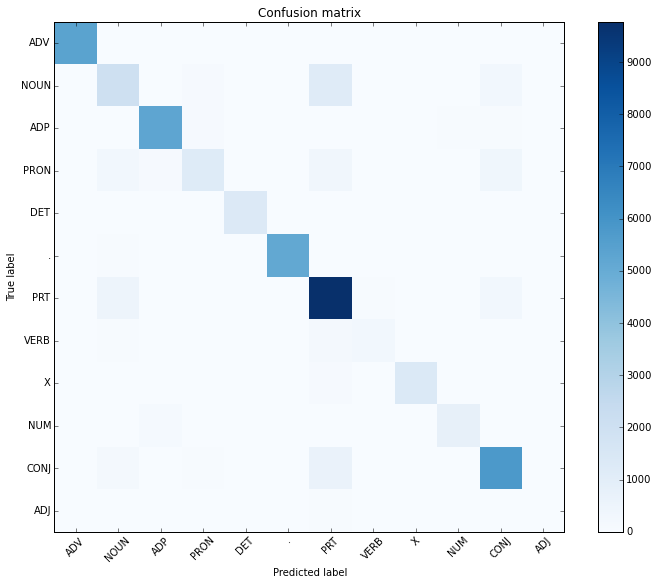

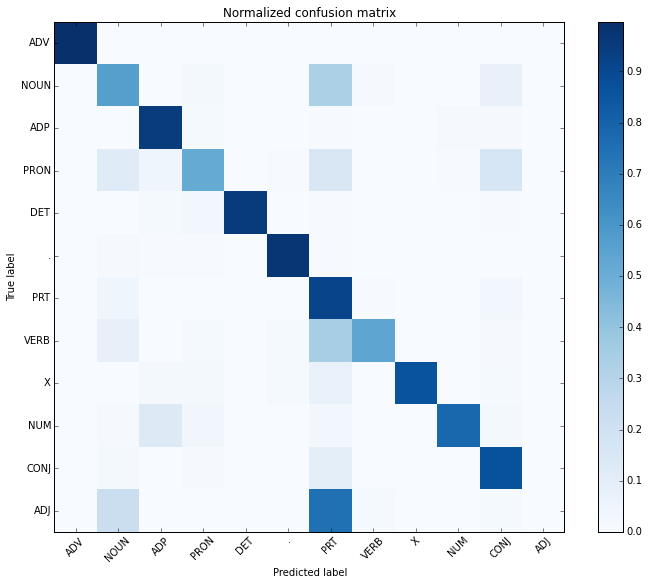

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test_actual, y_test_hat)
np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [14]:
# Challenge: change the MLP class to allow adding multiple hidden layers
# -- how can you leverage the HiddenLayer class to do that? 
# Challenge: compare performance with different kinds of regularization
